### RBG Explorers

# Synthetic Generation

Notebook covering synthetic gerenation to evaluate best fit with RGB seismic

Set up a `conda` environment with:

    conda create -n welly python=3.6 matplotlib=2.0 scipy pandas

You'll need `welly` in your environment:

    conda install tqdm  # Should happen automatically but doesn't
    pip install welly
    
This will also install the latest versions of `striplog` and `lasio`.

In [1]:
import welly

In [14]:
ls logs/*.las

logs/F02-01_F02-01_Set.las     logs/F03-06_F03-06_Set.las
logs/F03-03_F03-03_Set.las     logs/F06-01_F06-01_Set.las
logs/F03-04_F03-04_Set.las     logs/F06-02_F06-02_Set.las
logs/F03-05_F03-05-S1_Set.las


In [21]:
import lasio

l = lasio.read('logs/F02-01_F02-01_Set.las')


Header section Parameter regexp=~P was not found.


In [41]:
from welly import Well

w = Well.from_las('logs/F02-01_F02-01_Set.las')  # Line 6.

Header section Parameter regexp=~P was not found.


In [42]:
w

Well(uwi: '', 5 curves: ['NPHI', 'DRHO', 'GR', 'RHOB', 'DT'])

In [79]:
wdf = w.df()
wdf['AI'] = w.df()['RHOB']*w.df()['DT']
wdf.head()

,NPHI,DRHO,GR,RHOB,DT,AI
DEPT,,,,,,
48.2001,NaN,NaN,NaN,NaN,NaN,NaN
48.3001,NaN,NaN,NaN,NaN,NaN,NaN
48.4001,NaN,NaN,NaN,NaN,NaN,NaN
48.5001,NaN,NaN,NaN,NaN,NaN,NaN
48.6001,NaN,NaN,NaN,NaN,NaN,NaN


/Users/thomassandison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


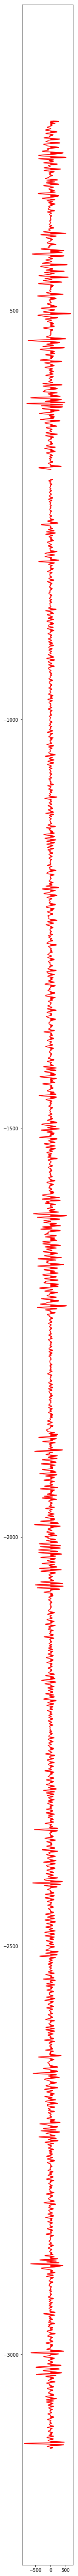

In [115]:
import bruges
import numpy as np
import matplotlib.pyplot as plt

w = bruges.filters.ricker(duration=0.1, dt=0.001, f=25)
synth = np.convolve(wdf['AI'],w, mode='same')

fig = plt.figure(figsize=[2,102])
plt.plot(synth,-wdf.index.values, c='r')
plt.fill_betweenx(-wdf.index.values, synth, 0, synth>0.0, color='r', alpha=1)

/Users/thomassandison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


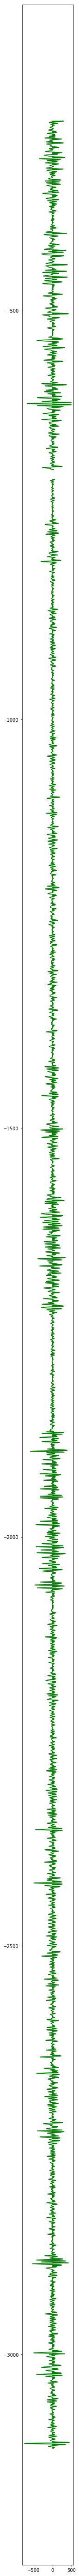

In [118]:
import bruges
import numpy as np
import matplotlib.pyplot as plt

w = bruges.filters.ricker(duration=0.1, dt=0.001, f=35)
synth = np.convolve(wdf['AI'],w, mode='same')

fig = plt.figure(figsize=[2,102])
plt.plot(synth,-wdf.index.values, c='g')
plt.fill_betweenx(-wdf.index.values, synth, 0, synth>0.0, color='g', alpha=1)

In [130]:
l.header.keys()

dict_keys(['Version', 'Well', 'Curves', 'Parameter', 'Other'])

In [131]:
l.header['Curves']

[CurveItem(mnemonic=DEPT, unit=Meter, value=, descr=1, original_mnemonic=DEPT, data.shape=(30759,)),
 CurveItem(mnemonic=NPHI, unit=V/V, value=, descr=2, original_mnemonic=NPHI, data.shape=(30759,)),
 CurveItem(mnemonic=DRHO, unit=G/C3, value=, descr=3, original_mnemonic=DRHO, data.shape=(30759,)),
 CurveItem(mnemonic=GR, unit=GAPI, value=, descr=4, original_mnemonic=GR, data.shape=(30759,)),
 CurveItem(mnemonic=RHOB, unit=G/C3, value=, descr=5, original_mnemonic=RHOB, data.shape=(30759,)),
 CurveItem(mnemonic=DT, unit=US/F, value=, descr=6, original_mnemonic=DT, data.shape=(30759,))]

## Dealing with the shallow section

To deal with the shallow section, we first need to adjust the depths relative to sea level by subtracting the KB elevation (30.2 m) from the measured depths,

If we now integrate the sonic log, we see that time t = 0 corresponds to a depth of 347 m TVDss. To position the top of the log at the correct travel time on the seismic section, we need to use the thickness, and replacement velocities for both the water column, and the section above the log.

The replacement velocity for water = 1480 m/s

The replacement velocity for section above log = 1600 m/s

*Update - missing variables now defined (Jan 5, 2014)*

In [144]:
wdf = wdf.loc[~np.isnan(wdf['DT']),:]
wdf.index.values[0]

263.2001

In [163]:
# kb = Kelly Bushing elevation(m) 35.9
# wd = Depth to Sea Floor below sea level (m) 44.5
# top_log = top of log (m) 

kb = -35.9
wd = 44.5
top_log = wdf.index.values[0]

w_vel = 1480  # velocity of sea water [m/s]

EGL_time = 2.0 * kb / w_vel
print ("Ground Level time above SRD :", EGL_time)

water_twt = 2.0 * (wd + EGL_time) / w_vel
print ("water_time: ", water_twt)

repl_vel = 1600 # m/s
repl_time = 2.0 * top_log / w_vel
print ("two-way-replacement time: ", repl_time)

log_start_time = water_twt + repl_time 
print ('log_start_time:', log_start_time)

def tvdss(md):
    "assumes a vertical well"
    return md - kb

top_log_TVDss = kb - wd


Ground Level time above SRD : -0.04851351351351351
water_time:  0.06006957633308985
two-way-replacement time:  0.35567581081081084
log_start_time: 0.4157453871439007


The starting time for our log is :

In [164]:
print (log_start_time, ' seconds')


0.4157453871439007  seconds


### Computing the time-to-depth relationship

The time-to-depth relationship is obtained by scaling the sonic log by the sample interval (6" or 0.1524 m) and by calling <code>np.cumsum()</code> on it.

In [179]:
# two-way-time to depth relationship
interval = wdf.index.values[1]-wdf.index.values[0]
scaled_dt = interval * np.nan_to_num(wdf['DT']) / 1e6

tcum = 2 * np.cumsum(scaled_dt)
tdr = tcum + log_start_time

### Compute acoustic impedance

In [174]:
# Z = (1e6/wdf['DT']) * wdf['RHOB']


### Compute reflection coefficient series

In [180]:
RC = (wdf['AI'][1:] - wdf['AI'][:-1]) / (wdf['AI'][1:] + wdf['AI'][:-1])

### Code to create figure

Plot the logs in the depth domain

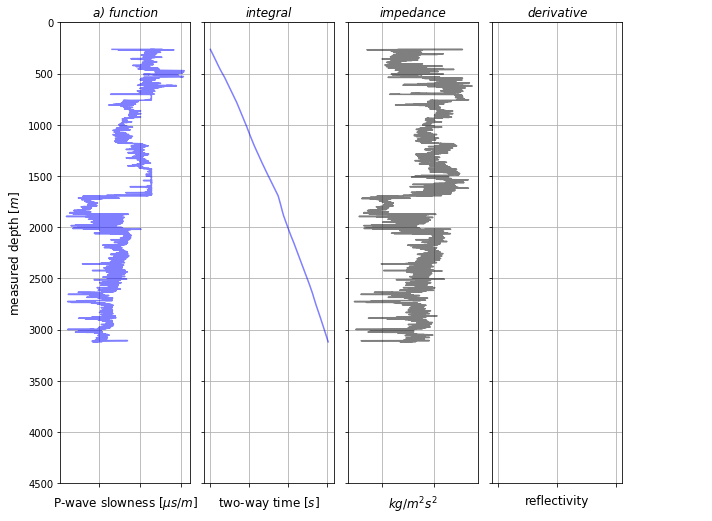

In [187]:
f1 = plt.figure(figsize = (10,8))
DT = wdf['DT']
z = wdf.index.values
AI = wdf['AI']

ax1 = f1.add_axes([0.1, 0.1, 0.18, 0.8])
ax1.plot( DT, z,'b', alpha=0.5)
ax1.set_title('a) function', style = 'italic')
ax1.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel('P-wave slowness '+ r'$[\mu s/m]$', fontsize = '12')
ax1.set_ylim(0, 4500)
ax1.set_xticklabels('')
ax1.invert_yaxis()
ax1.grid()

ax2 = f1.add_axes([0.3 , 0.1, 0.18, 0.8])
ax2.plot(tcum, z, 'b', alpha = 0.5)
ax2.set_title('integral', style = 'italic')
ax2.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
ax2.invert_yaxis()
ax2.set_yticklabels('')
ax2.set_xticklabels('')
ax2.set_ylim(4500, 0)
ax2.grid()

ax3 = f1.add_axes([0.5, 0.1, 0.18, 0.8])
ax3.plot( AI, z, 'k', alpha=0.5)
ax3.set_title('impedance', style = 'italic')
ax3.set_xlabel(r'$kg/m^2s^2$', fontsize = '12')
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticklabels('')
ax3.set_ylim(4500, 0)
ax3.grid()

ax4 = f1.add_axes([0.7, 0.1, 0.18, 0.8])
ax4.plot( RC, z, 'k', alpha=0.5)
ax4.set_title('derivative', style = 'italic')
ax4.set_xlabel('reflectivity', fontsize = '12')
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticklabels('')
ax4.set_ylim(4500, 0)
ax4.grid()

# for i in range (4):
#     for top in tops.values() :
#         f1.axes[i].axhline( y = float(top), color = 'b', lw = 1, 
#                             ls = ':',  
#                             alpha = 0.5, xmin = 0.05, xmax = 0.95 )

# for top, depth in tops.iteritems():
#     ax4.text( x = max(ax4.xaxis.get_data_interval())*1.0,
#               y = float(depth), s = top,
#                          alpha=0.75, color='k',
#                          fontsize = '10',
#                          horizontalalignment = 'left',
#                          verticalalignment = 'center',
#                          bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
#                          weight = 'light')

ax5 = f1.add_axes([0.8, 0.1, 0.18, 0.8])
ax5.invert_yaxis()
ax5.set_ylim(4500, 0)
ax5.set_axis_off()

### Converting logs to two-way-travel time

But we need the functions represented by travel time

In [191]:
# RESAMPLING FUNCTION
dt = 0.004
maxt = 3.0

t = np.arange(0, maxt, dt) 

Z_t = np.interp(x = t, xp = tdr, fp = AI)

RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1])

## Creating the synthetic

In [192]:
# Define a wavelet.

# w = bruges.filters.ricker(duration=0.1, dt=0.001, f=25)
# synth = np.convolve(wdf['AI'],w, mode='same')

# def ricker(f, length, dt):
#     t = np.linspace(-length / 2, (length-dt) / 2, length / dt)
#     y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
#     return t, y

In [201]:
RC_t = np.nan_to_num(RC_t)
tw, w = ricker (f=25, length = 0.512, dt = 0.004)
synth = np.convolve(w, RC_t, mode='same')

/Users/thomassandison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


### Code to create figure

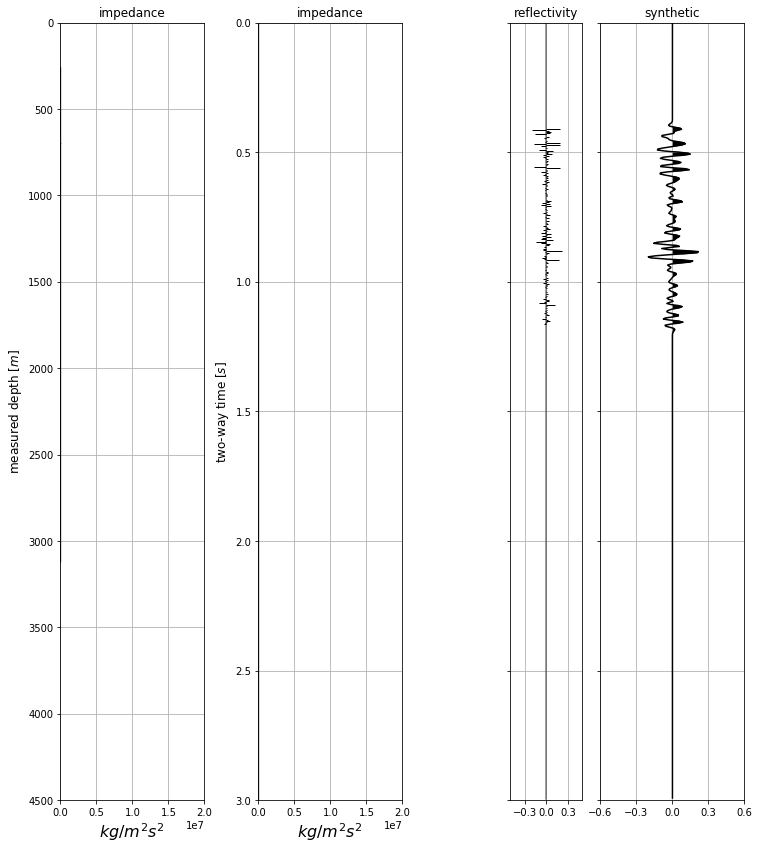

In [198]:
f2 = plt.figure(figsize=[10,12])

ax1 = f2.add_axes([0.05, 0.1, 0.2, 0.9])
ax1.plot(AI, z,'k', alpha=0.75)
ax1.set_title('impedance')
ax1.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax1.set_ylim(0, 4500)
ax1.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax1.invert_yaxis()
ax1.grid()

ax2 = f2.add_axes([0.325, 0.1, 0.2, 0.9])
ax2.plot(Z_t, t,'k', alpha=0.75)
ax2.set_title('impedance')
ax2.set_ylabel('two-way time ' + '$[s]$', fontsize = '12' )
ax2.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax2.set_ylim(0, 3)
ax2.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax2.invert_yaxis()
ax2.grid()

ax3 = f2.add_axes([0.675, 0.1, 0.1, 0.9])
ax3.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
ax3.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
ax3.set_title('reflectivity')
ax3.set_xlabel('', fontsize = '10')
ax3.set_ylim(0, 3)
ax3.set_xlim(-0.5, 0.5)
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticks([-0.3, 0, 0.3] )
ax3.grid()

ax4 = f2.add_axes([0.8, 0.1, 0.2, 0.9])
ax4.plot(synth, t[:-1],'k')
ax4.fill_betweenx(t[:-1], synth,  0,  synth > 0.0,  color='k', alpha = 1.0)
ax4.set_title('synthetic')
ax4.set_xlabel('', fontsize = '10')
ax4.set_ylim(0, 3)
ax4.set_xlim(-0.05, 0.05)
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticks([-0.6, -0.3, 0, 0.3, 0.6 ] )
ax4.grid()

# for i in range(1):
#     for top, depth in tops.iteritems():
#         f2.axes[i].axhline( y = float(depth), color = 'b', lw = 2, 
#                             alpha = 0.5, xmin = 0.05, xmax = 0.95 )
#         f2.axes[i].text( x = 1e7, y = float(depth)-0.015, s = top,
#                          alpha=0.75, color='k',
#                          fontsize = '12',
#                          horizontalalignment = 'center',
#                          verticalalignment = 'center',
#                          bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
#                          weight = 'light')
        

# for i in range(1,4):
#     for twt in tops_twt.values():
#         f2.axes[i].axhline( y = float(twt), color = 'b', lw = 2, 
#                     alpha = 0.5, xmin = 0.05, xmax = 0.95)
# for i in range(1,2):
#     for top, twt in tops_twt.iteritems():
#         f2.axes[i].text( x = 2.75e7, y = float(twt), s = top,
#                          alpha=0.75, color='k',
#                          fontsize = '12',
#                          horizontalalignment = 'center',
#                          verticalalignment = 'center',
#                          bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
#                          weight = 'light'
#                          )

## Comparison with real data

real data is located at trace 77 of 500

In [30]:
traces = np.loadtxt('PenobXL_1155.txt')

# rearrange traces for plotting
traces = np.fliplr(np.transpose(traces))

### Code to create figure

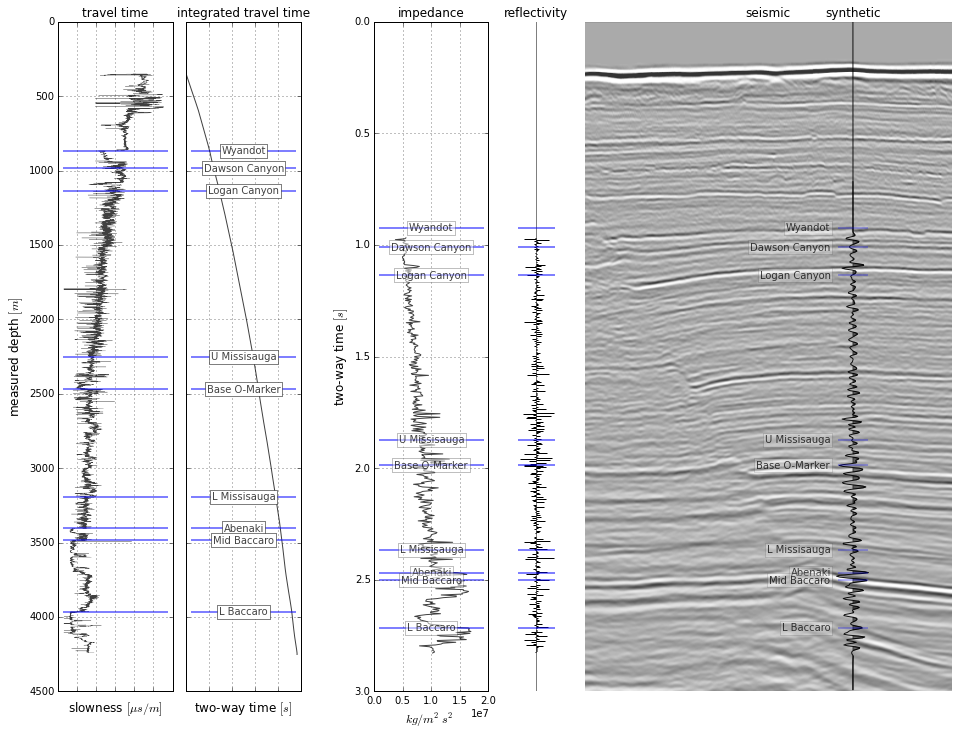

In [31]:
import matplotlib.gridspec as gridspec

f3 = plt.figure(figsize=[16,12])

gs = gridspec.GridSpec(1, 6, width_ratios = [1.25, 1.25, 0.5, 1.25, 0.75, 4])

# depth domain

axa = plt.subplot(gs[0])
axa.plot( DT, z,'k', alpha=0.75, lw=0.25)
axa.set_title('travel time')
axa.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
axa.set_xlabel('slowness 'r'$[\mu s/m]$', fontsize = '12')
axa.set_ylim(0, 4500)
axa.set_xticklabels('')
axa.invert_yaxis()
axa.grid()
gs.update(wspace=0.1)

axb = plt.subplot(gs[1])
axb.plot(tcum, z, 'k', alpha = 0.75)
axb.set_title('integrated travel time')
axb.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
axb.invert_yaxis()
axb.set_yticklabels('')
axb.set_xticklabels('')
axb.set_ylim(4500, 0)
axb.grid()

for top, depth in tops.iteritems():
    axa.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.text( x = 1.25, y = float(depth)-0.015, s = top,
                         alpha=0.75, color='k',
                         fontsize = '10',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1.0, lw = 0.5),
                         weight = 'light')

# time domain

#white space between depth and time plots
axoff = plt.subplot(gs[2])
axoff.set_axis_off()

axc = plt.subplot(gs[3])
axc.plot( Z_t, t, 'k', alpha=0.75)
axc.set_title('impedance')
axc.set_ylabel('two-way time '+ '$[s]$', fontsize = '12' )
axc.set_xlabel(r'$kg / m^2s^2$ ', fontsize = '12')
axc.set_ylim(0, 3)
axc.set_xlim(0, 2e7)
axc.invert_yaxis()
axc.grid()

for top, twt in tops_twt.iteritems():
    axc.axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
    axc.text(x = 1e7, y = float(twt), s = top,
                        alpha=0.75, color='k',
                        fontsize = '10',
                        horizontalalignment = 'center',                             
                        verticalalignment = 'center',
                        bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                        weight = 'light')     

axd = plt.subplot(gs[4])
axd.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
axd.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
axd.set_title('reflectivity')
axd.set_xlabel('', fontsize = '12')
axd.set_ylim(0, 3)
axd.set_xlim(-0.5, 0.5)
axd.invert_yaxis()
axd.set_yticklabels('')
axd.set_axis_off()
axd.grid()
for depth in tops_twt.values():
    axd.axhline(y = float(depth), color = 'b', lw = 2, 
                alpha = 0.5, xmin = 0.25, xmax = 0.75)

axe = plt.subplot(gs[5])
axe.imshow( traces[:750,100:], cmap = 'Greys', 
           vmin = -7000, vmax = 7000, alpha = 0.8,
           aspect = 'auto'
           )
axe.set_axis_off()
axe.set_title('seismic')

# put synthetic on seismic
bottom = axe.get_position().get_points()[0][1]
top =  axe.get_position().get_points()[1][1]

axf = axe.figure.add_axes([0.79, bottom, 0.05, top-bottom])
gain_synth = 1
axf.plot(gain_synth * synth, t[:-1], 'k', alpha = 0.9)
axf.fill_betweenx(t[:-1], gain_synth * synth,  0, 
                  gain_synth * synth > 0.0,
                  color = 'k', alpha = 0.5)
axf.set_title('synthetic')
axf.set_xlabel('', fontsize = '12')
axf.set_ylim(0, 3)
axf.set_xlim(-0.5 ,0.5)
axf.invert_yaxis()
axf.set_yticklabels('')
axf.set_axis_off()
axf.grid()
for top, twt in tops_twt.iteritems():
    axf.axhline( y = float(twt), color = 'b', lw = 2, 
                alpha = 0.25, xmin = 0.25, xmax = 0.75)
    axf.text(x = -0.4, y = float(twt), s = top,
             alpha=0.75, color='k',
             fontsize = '10',
             horizontalalignment = 'right',
             verticalalignment = 'center',
             bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
             weight = 'light')

#f3.savefig('Figure_1.png', facecolor = 'white', dpi = 300)

/Users/thomassandison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


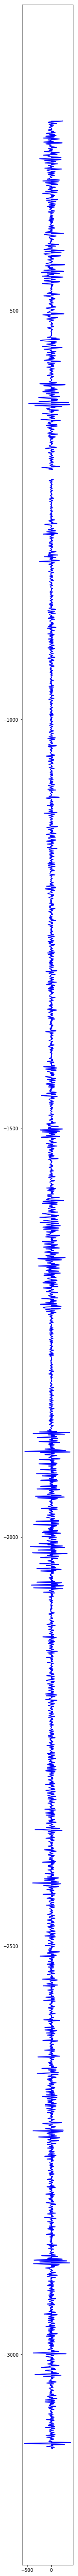

In [119]:
import bruges
import numpy as np
import matplotlib.pyplot as plt

w = bruges.filters.ricker(duration=0.1, dt=0.001, f=45)
synth = np.convolve(wdf['AI'],w, mode='same')

fig = plt.figure(figsize=[2,102])
plt.plot(synth,-wdf.index.values, c='b')
plt.fill_betweenx(-wdf.index.values, synth, 0, synth>0.0, color='b', alpha=1)